In [2]:
from observational_fear import load
import pandas as pd
from pathlib import Path
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt


DATA_DIR = Path(r"F:\OFL\one-p experiment\data")
FIG_DIR = Path(r"C:\Users\roryl\repos\observational-fear\figs")

In [3]:
dftr = load.load_freeze_cache(DATA_DIR, "day2", startstop="start", dummy=False).assign(is_dummy=False)
dftf = load.load_freeze_cache(DATA_DIR, "day2", startstop="start", dummy=True).assign(is_dummy=True)

In [4]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC, LinearSVC
from scipy.ndimage import gaussian_filter1d
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

def fit_model(X, y, pipe, shuffle=True):
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=shuffle)
    pipe.fit(X_train, y_train)
    y_hat = pipe.predict(X_test)
    f1 = metrics.f1_score(y_test, y_hat)
    return f1, pipe

pipe = make_pipeline(StandardScaler(), GaussianNB())
# pipe = make_pipeline(RandomForestClassifier())


In [5]:
dftr = load.load_freeze_cache(DATA_DIR, "day2", startstop="start", dummy=False).assign(is_dummy=False)
dftf = load.load_freeze_cache(DATA_DIR, "day2", startstop="start", dummy=True).assign(is_dummy=True)
mice = dftr.mouse.unique()

In [123]:
out = []
for session in ("day2", "day4"):
    for start_stop in ("start", "stop"):
        print(f"{session} - {start_stop}")
        dftr = load.load_freeze_cache(DATA_DIR, session, startstop=start_stop, dummy=False).assign(is_dummy=False)
        dftf = load.load_freeze_cache(DATA_DIR, session, startstop=start_stop, dummy=True).assign(is_dummy=True)
        mice = dftr.mouse.unique()
        reses = []
        for mouse in mice:
            print(f"\t - {mouse}")
            dftr_mouse = dftr.loc[lambda x: x.mouse == mouse]
            dftf_mouse = dftf.loc[lambda x: x.mouse == mouse]
            aligned_vals = dftr.aligned.unique()
            f1s = []
            for offset in aligned_vals:
                dftr_sub = dftr_mouse.loc[lambda x: x.aligned == offset].pivot_table(columns="new_id", values="value", index="event")
                dftf_sub = dftf_mouse.loc[lambda x: x.aligned == offset].pivot_table(columns="new_id", values="value", index="event")
                X = pd.concat([dftr_sub, dftf_sub]).reset_index(drop=True)
                y = pd.Series([1] * len(dftr_sub) + [0] * len(dftf_sub))
                f1, _ = fit_model(X, y, clone(pipe))
                f1s.append(f1)
            res = pd.DataFrame({"offset": aligned_vals, "f1score": f1s, "mouse": mouse})
            reses.append(res)
        df_res = pd.concat(reses).reset_index()
        df_res = df_res.assign(session=session, start_stop=start_stop)
        out.append(df_res)
        print(len(out))

day2 - start
	 - B17274
	 - PL-OFL-2
	 - B43396
	 - B17276
	 - PL-OFL-5
	 - PL-OFL-7
	 - PL-OFL-4
	 - PL-OFL-6
1
day2 - stop
	 - B17274
	 - PL-OFL-2
	 - B43396
	 - B17276
	 - PL-OFL-5
	 - PL-OFL-7
	 - PL-OFL-4
	 - PL-OFL-6
2
day4 - start
	 - B17274
	 - B43396
	 - B17276
	 - PL-OFL-5
	 - PL-OFL-7
	 - PL-OFL-4
	 - PL-OFL-6
3
day4 - stop
	 - B17274
	 - B43396
	 - B17276
	 - PL-OFL-5
	 - PL-OFL-7
	 - PL-OFL-4
	 - PL-OFL-6
4


In [124]:
len(out)

4

In [125]:
def plot_res(df, figsize=None):
    plt.figure(figsize=figsize)
    plt.title(f"Freeze {start_stop} {session}")
    sns.lineplot(data=df, x="offset", y="f1score", color="black")
    plt.xlabel("Time Relative to Freeze {start_stop}")
    plt.ylabel("Decoder Performance [F1 Score]")
    plt.axhline(0.5, color="grey")
    plt.axvline(0, color="grey")
    plt.ylim(0, 1)


# df_res.to_csv(DATA_DIR / "derived" / f"decorder_res_{session}_{start_stop}.csv", index=False)

In [126]:
import ezbootstrap as ez
import warnings
warnings.filterwarnings("ignore")

from scipy.stats import ttest_1samp
from observational_fear.stats import p_adjust

def one_sample_test(x, null_mean=0.5, size=1000):
    obs_mean = x.mean()
    adjusted = x - obs_mean + null_mean
    reps = ez.bs_1sample(adjusted, func=lambda x: np.mean(x), size=size)
    return (reps > obs_mean).mean()


def t_one_sample(x, popmean=0.5):
    stat, p = ttest_1samp(x, popmean=popmean, alternative="greater")
    return p

def get_p_vals(decoding_output):
    def _t_one_sample(x, popmean=0.5):
        stat, p = ttest_1samp(x, popmean=popmean, alternative="greater")
        return p

    return (
        decoding_output
        .groupby(["session", "offset", "start_stop"], as_index=False)["f1score"]
        .apply(_t_one_sample).assign(p=lambda x: p_adjust(x.f1score))
        .drop("f1score", axis=1)
    )

decoding_output = pd.concat(out)
decoding_output = decoding_output.merge(get_p_vals(decoding_output))

In [127]:
decoding_output

,index,offset,f1score,mouse,session,start_stop,p
0,0,-0.2,0.743802,B17274,day2,start,0.041719
1,0,-0.2,0.494845,PL-OFL-2,day2,start,0.041719
2,0,-0.2,0.480769,B43396,day2,start,0.041719
3,0,-0.2,0.643678,B17276,day2,start,0.041719
4,0,-0.2,0.712644,PL-OFL-5,day2,start,0.041719
...,...,...,...,...,...,...,...
3025,100,-5.0,0.482759,B17276,day4,stop,0.322688
3026,100,-5.0,0.650000,PL-OFL-5,day4,stop,0.322688
3027,100,-5.0,0.509091,PL-OFL-7,day4,stop,0.322688
3028,100,-5.0,0.540541,PL-OFL-4,day4,stop,0.322688


In [128]:
def plot_output(df,  y_lims=(0.35, 0.8), ax=None, sig_mark=None):
    if sig_mark is None:
        sig_mark = y_lims[1] - 0.05
    if ax is None:
        _, ax = plt.subplots()
    sig = (
        df
        .sort_values("offset")[["offset", "p"]]
        .assign(sig=lambda x: np.where(x.p< 0.05, sig_mark, np.nan)).drop_duplicates()
        .dropna()
    )
    sns.lineplot(data=df, x="offset", y="f1score", color="black", ax=ax)
    ax.scatter(sig.offset, sig.sig, color="black")
    ax.axhline(0.5, color="grey")
    ax.axvline(0, color="grey")
    ax.set_ylim(*y_lims)
    ax.set_ylabel("Decoder Performance [F1 Score]")
    return ax

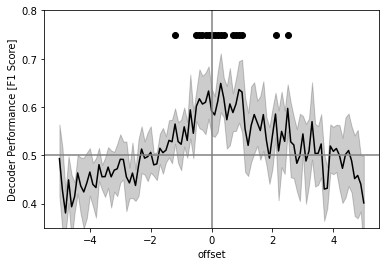

In [139]:
plot_output(decoding_output.loc[lambda x: (x.session=="day2") & (x.start_stop=="start")])
plt.savefig(FIG_DIR / "decoding-day2-start.svg")

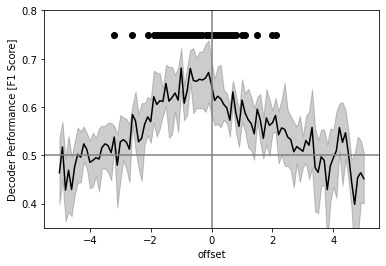

In [138]:
plot_output(decoding_output.loc[lambda x: (x.session=="day2") & (x.start_stop=="stop")])
plt.savefig(FIG_DIR / "decoding-day2-stop.svg")

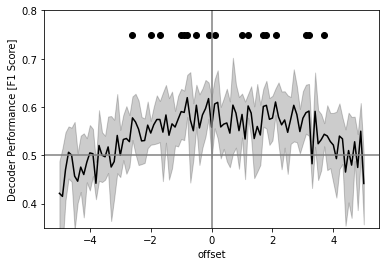

In [137]:
plot_output(decoding_output.loc[lambda x: (x.session=="day4") & (x.start_stop=="start")])
plt.savefig(FIG_DIR / "decoding-day4-start.svg")

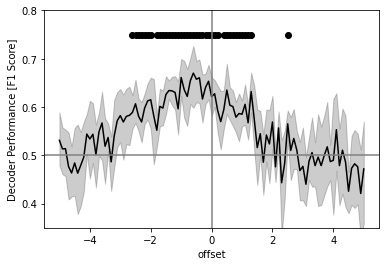

In [136]:
plot_output(decoding_output.loc[lambda x: (x.session=="day4") & (x.start_stop=="stop")])
plt.savefig(FIG_DIR / "decoding-day4-stop.svg")

In [135]:
decoding_output.drop("index", axis=1).to_csv(DATA_DIR / "decoding_output.csv", index=False)